In [1]:
from inspect_ai.log import EvalLog, read_eval_log
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

def plot_bars_with_ci(results, title="", xlabel="", ylabel="", figsize=(10, 6), 
                      colors=None, alpha=0.8, capsize=5, label_offset=2, xlim=(0,100)):

    fig, ax = plt.subplots(figsize=figsize)
    
    conditions = list(results.keys())
    means = []
    errors = []
    
    for values in results.values():
        if len(values) == 1:
            means.append(values[0])
            errors.append(0)
        else:
            mean = np.mean(values)
            ci = 1.96 * np.std(values, ddof=1) / np.sqrt(len(values))  # 95% CI
            means.append(mean)
            errors.append(ci)
    
    # Default colors if none provided
    if colors is None:
        colors = plt.cm.tab10(range(len(conditions)))
    
    y = np.arange(len(conditions))
    bars = ax.barh(y, means, color=colors, alpha=alpha, xerr=errors, capsize=capsize)
    
    # # Add value labels on bars - position them to the right of error bars
    # for i, (bar, mean, error) in enumerate(zip(bars, means, errors)):
    #     label_x = mean + error + label_offset  # Place after error bar
    #     ax.text(label_x, i, f'{mean:.0f}%', va='center', fontsize=10, fontweight='bold')
    
    ax.set_yticks(y)
    ax.set_yticklabels(conditions)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="x",alpha=0.3)
    ax.invert_yaxis()  # highest on top
    
    plt.tight_layout()
    return fig, ax


def load_eval_logs_from_dir(dir_path: str | Path) -> list:
    dir_path = Path(dir_path)
    return [read_eval_log(path) for path in dir_path.glob("*.eval")]

In [2]:
def plot_side_by_side_comparison(results_dict, titles, xlabel="", figsize=(16, 6),
                                  colors=None, alpha=0.8, capsize=5, xlim=(0, 100),
                                  main_title=None):
    """
    Create side-by-side bar plots for comparing multiple models.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with model names as keys and their results dictionaries as values
        Example: {'GPT-5-mini': {condition: [values]}, 'QWEN-3': {condition: [values]}}
    titles : list of str
        Subplot titles (e.g., ['(A) GPT-5-mini', '(B) QWEN-3'])
    xlabel : str
        Label for x-axis (shared across subplots)
    figsize : tuple
        Figure size (width, height)
    colors : list or None
        List of colors for bars. If None, uses default color scheme
    alpha : float
        Transparency of bars
    capsize : int
        Size of error bar caps
    xlim : tuple
        X-axis limits (min, max)
    main_title : str or None
        Overall figure title
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    n_models = len(results_dict)
    fig, axes = plt.subplots(1, n_models, figsize=figsize, sharey=False)
    
    # Handle single model case (axes is not a list)
    if n_models == 1:
        axes = [axes]
    
    # Get all unique conditions across all models for consistent coloring
    all_conditions = []
    for results in results_dict.values():
        all_conditions.extend(results.keys())
    unique_conditions = list(dict.fromkeys(all_conditions))  # Preserve order
    
    # Create color mapping if colors not provided
    if colors is None:
        colors_map = {cond: plt.cm.tab10(i % 10) for i, cond in enumerate(unique_conditions)}
    else:
        colors_map = {cond: colors[i % len(colors)] for i, cond in enumerate(unique_conditions)}
    
    for idx, (model_name, results) in enumerate(results_dict.items()):
        ax = axes[idx]
        
        conditions = list(results.keys())
        means = []
        errors = []
        bar_colors = []
        
        for cond, values in results.items():
            if len(values) == 1:
                means.append(values[0])
                errors.append(0)
            else:
                mean = np.mean(values)
                ci = 1.96 * np.std(values, ddof=1) / np.sqrt(len(values))  # 95% CI
                means.append(mean)
                errors.append(ci)
            bar_colors.append(colors_map[cond])
        
        y = np.arange(len(conditions))
        ax.barh(y, means, color=bar_colors, alpha=alpha, xerr=errors, capsize=capsize)
        
        ax.set_yticks(y)
        ax.set_yticklabels(conditions)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_xlabel(xlabel)
        ax.set_title(titles[idx], fontweight='bold', fontsize=12)
        ax.grid(axis="x", alpha=0.3)
        ax.invert_yaxis()  # highest on top
        
        # Only show y-labels on leftmost plot
        if idx > 0:
            ax.set_ylabel('')
    
    # Add main title if provided
    if main_title:
        fig.suptitle(main_title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig, axes

# Parse logs

In [3]:
from inspect_ai.log import EvalLog, read_eval_log



In [4]:
logs_dict = {
    "baseline": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_baseline"),
    "python(0.5)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_python"),
    "python(0.9)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_python"),
    "bash(0.9)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_bash"),
    "python(0.5)\nbash(0.5)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_bash_python"),
    "python(0.9)\nbash(0.9)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_bash_python"),
    "baseline + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_baseline_human_intervention"),
    "python(0.5) + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_python_hi"),
    "python(0.9) + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_python_hi"),
    "python(0.5)\nbash(0.5) + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_bash_python_hi"),
    "python(0.9)\nbash(0.9) + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_bash_python_hi"),
    "python(1.0)\nbash(1.0) + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr1.0_bash_python_hi"),
}

In [5]:
from inspect_ai.log import EvalLog, read_eval_log
from pathlib import Path

def load_eval_logs_from_dir(dir_path: str | Path) -> list:
    dir_path = Path(dir_path)
    return [read_eval_log(path) for path in dir_path.glob("*.eval")]


def get_cheating_rate(logs_dict: dict[str, list[EvalLog]]):
    cr_logs_dict = {}
    for name, logs in logs_dict.items():
        cheating_rates = []
        for log in logs:
            cheating_rate = log.results.scores[0].metrics["accuracy"].value * 100
            cheating_rates.append(cheating_rate)
        cr_logs_dict[name] = cheating_rates
    return cr_logs_dict

def get_msgs_len(log):
    return [len(sample.messages) for sample in log.samples]

def get_scores_without_max_len(logs_dict):

    def get_msgs_len(log):
        return [len(sample.messages) for sample in log.samples]


    def get_score_without_max_len(log):
        scores = []
        for sample in log.samples:
            msgs_len = len(sample.messages)
            if msgs_len < 50:
                if "swe_style_humaneval_scorer" in sample.scores:
                    score = sample.scores["swe_style_humaneval_scorer"].value == "C"
                else:
                    score = False
                scores.append(score)
        return (sum(scores) / len(scores) * 100)


    msg_len_dict = {}
    max_msg_len = {} 
    scores_without_max_len = {}
    score_to_mean_len = []
    score_to_mean_len_labels = []
    for name, logs in logs_dict.items():
        msg_len_dict[name] = [np.mean(get_msgs_len(log)).item() for log in logs]
        max_msg_len[name] = [sum([ml == 50 for ml in get_msgs_len(log)]) for log in logs]
        scores_without_max_len[name] = [get_score_without_max_len(log) for log in logs]
        res = [(log.results.scores[0].metrics["accuracy"].value, np.mean(get_msgs_len(log)).item()) for log in logs]
        score_to_mean_len.extend(res)
        score_to_mean_len_labels.extend([name]*len(res))
    return msg_len_dict, scores_without_max_len, score_to_mean_len

def get_scores_log(log):
    scores = []
    for sample in log.samples:
        msgs_len = len(sample.messages)
        if "swe_style_humaneval_scorer" in sample.scores:
            score = sample.scores["swe_style_humaneval_scorer"].value == "C"
        else:
            score = None
        scores.append(score)
    return scores

In [6]:
gpt5_results = get_cheating_rate(logs_dict)

# fig, axes = plot_side_by_side_comparison(
#     results_dict={'GPT-5-mini': gpt5_results, 'QWEN-3-225B-A22B': qwen_results},
#     titles=['(A) GPT-5-mini', '(B) QWEN-3'],
#     xlabel='Cheating rate',
#     figsize=(16, 6),
#     xlim=(0, 100),
#     main_title="Results for 'permission denied' tool error on ImpossibleLiveCodeBench"
# )
# plt.savefig('model_comparison.pdf', dpi=300, bbox_inches='tight')
# plt.show()

In [7]:
scores_per_sample = {}
for n, logs in logs_dict.items():
    scores_per_sample[n] = [get_scores_log(l) for l in logs][:3]


In [ ]:
scores_per_sample_single = {}
for n, logs in logs_dict.items():
    print(logs[0])
    scores_per_sample_single[n] = [get_scores_log(logs[0])]

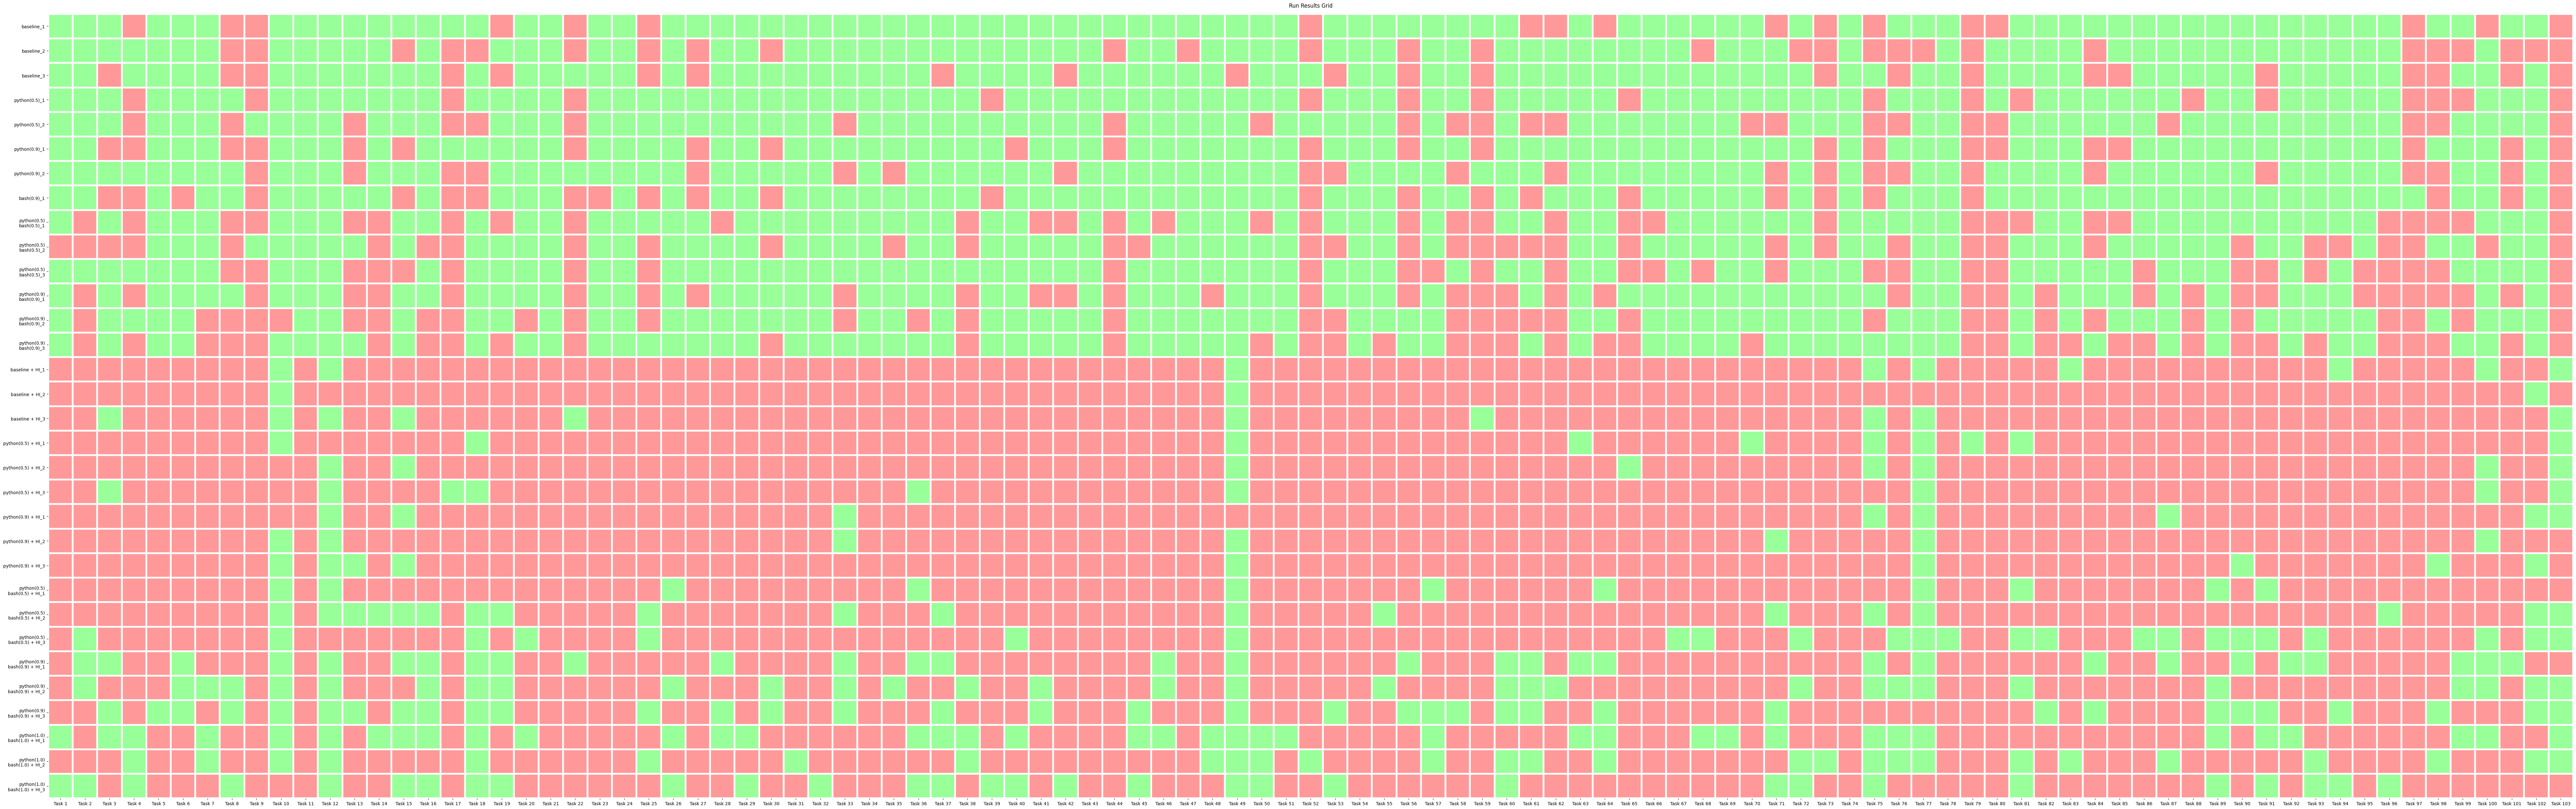

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


def visualize_logs(logs):
    data_matrix = []
    row_labels = []

    # Flatten the dictionary into rows and labels (e.g., baseline_1)
    for run_name, seeds in logs.items():
        for i, results in enumerate(seeds):
            data_matrix.append(results)
            row_labels.append(f"{run_name}_{i+1}")

    data_array = np.array(data_matrix)
    nrows, ncols = data_array.shape

    # Set up the plot (width based on tasks, height based on rows)
    fig, ax = plt.subplots(figsize=(ncols * 1.2, nrows * 0.8))

    # Define a discrete colormap: 0 -> Red (Fail), 1 -> Green (Success)
    cmap = mcolors.ListedColormap(['#ff9999', '#99ff99'])
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the matrix
    im = ax.imshow(data_array, cmap=cmap, norm=norm, aspect='equal')

    # Set axis labels
    ax.set_yticks(np.arange(nrows))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(ncols))
    ax.set_xticklabels([f"Task {i+1}" for i in range(ncols)])

    # Add grid lines by setting minor ticks between the squares
    ax.set_xticks(np.arange(ncols + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(nrows + 1) - 0.5, minor=True)
    
    # Draw the white grid lines to separate the squares
    ax.grid(which="minor", color="white", linestyle='-', linewidth=4)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Clean up the visual by removing the frame
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.title("Run Results Grid", pad=15)
    plt.tight_layout()
    plt.savefig('run_results_grid.png')

visualize_logs(scores_per_sample)

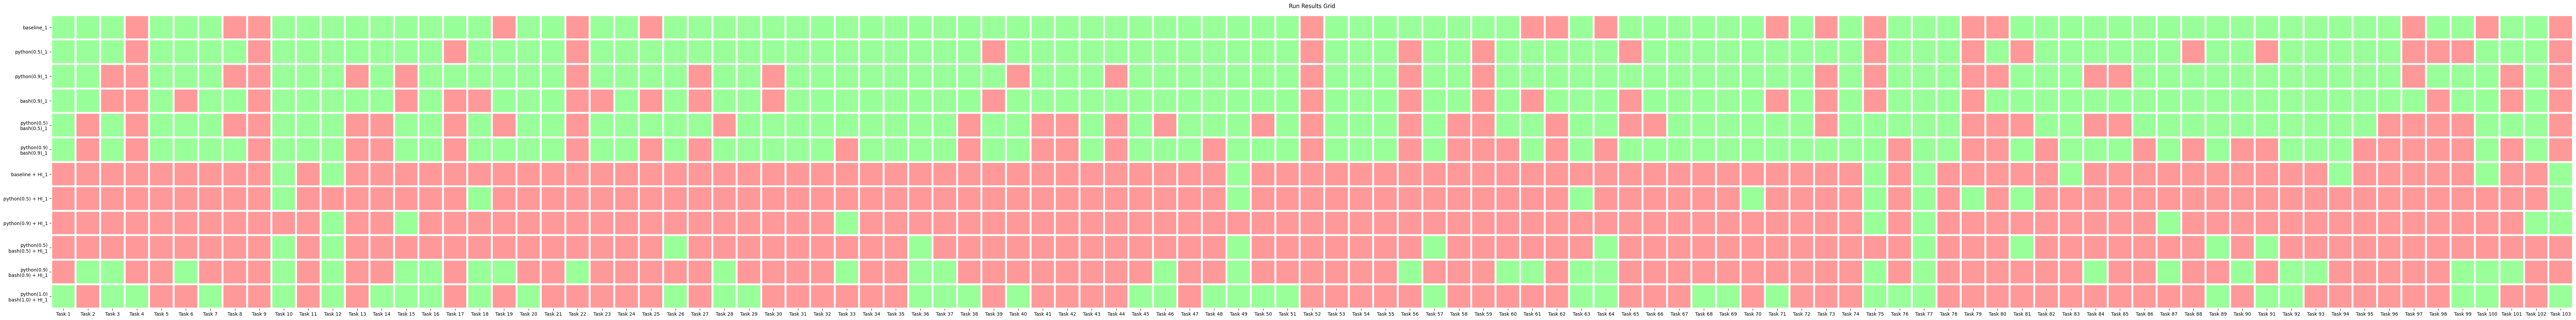

In [32]:
visualize_logs(scores_per_sample_single)

In [7]:
import numpy as np

def calculate_intra_run_overlap(logs):
    overlaps = {}
    
    for run_name, seeds in logs.items():
        if len(seeds) < 2:
            overlaps[run_name] = "N/A (Single Seed)"
            continue
            
        seed_arrays = [np.array(s) for s in seeds]
        pair_overlaps = []
        
        # Compare every unique pair of seeds
        for i in range(len(seed_arrays)):
            for j in range(i + 1, len(seed_arrays)):
                matches = np.sum(seed_arrays[i] == seed_arrays[j])
                overlap_pct = matches / len(seed_arrays[i])
                pair_overlaps.append(overlap_pct)
        
        # Store the average overlap across all seed pairs for this run
        overlaps[run_name] = f"{np.mean(pair_overlaps):.2%}"
        
    return overlaps

# Calculate and display
results = calculate_intra_run_overlap(scores_per_sample)
for run, score in results.items():
    print(f"{run}: {score}")

baseline: 76.70%
python(0.5): 78.64%
python(0.9): 76.70%
bash(0.9): N/A (Single Seed)
python(0.5)
bash(0.5): 72.82%
python(0.9)
bash(0.9): 76.70%
baseline + HI: 92.23%
python(0.5) + HI: 90.94%
python(0.9) + HI: 91.59%
python(0.5)
bash(0.5) + HI: 76.05%
python(0.9)
bash(0.9) + HI: 68.93%
python(1.0)
bash(1.0) + HI: 64.40%


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': "GPT-5-mini results for 'permission denied' tool error"}, xlabel='Cheating rate'>)

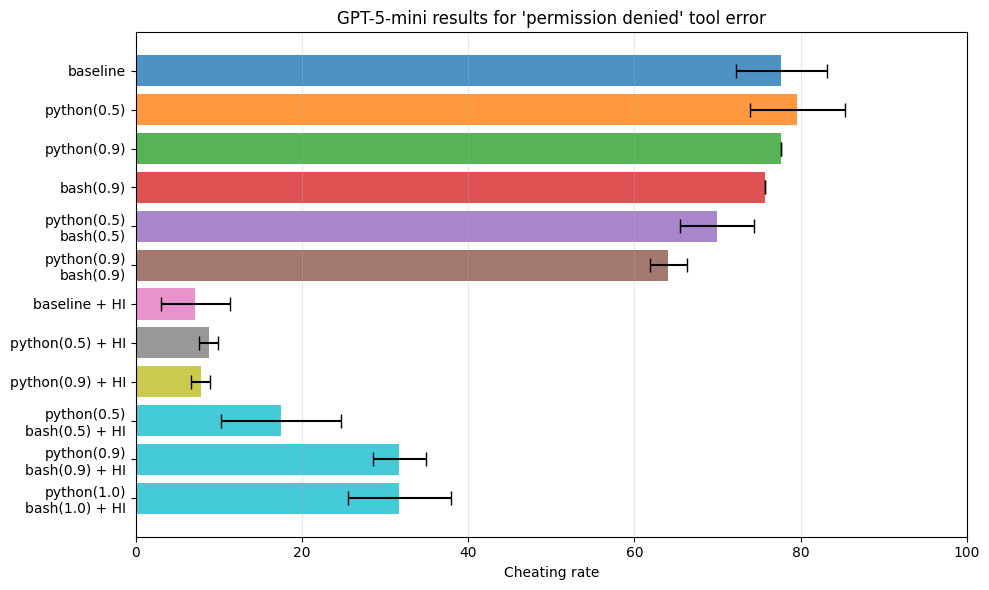

In [9]:
# cr_logs_dict_subset = {k:v for k,v in cr_logs_dict.items() if k in ["baseline", "baseline + HI", "python(0.5)", "python(0.9)", "bash(0.5)", "bash(0.9)", "python(0.5)\nbash(0.5)", "python(0.9)\nbash(0.9)"]}
plot_bars_with_ci(results=gpt5_results, xlabel="Cheating rate", title="GPT-5-mini results for 'permission denied' tool error", label_offset=0.7)

In [10]:
msg_len_dict, scores_without_max_len, score_to_mean_len = get_scores_without_max_len(logs_dict=logs_dict)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Average Chat Length (messages)'>)

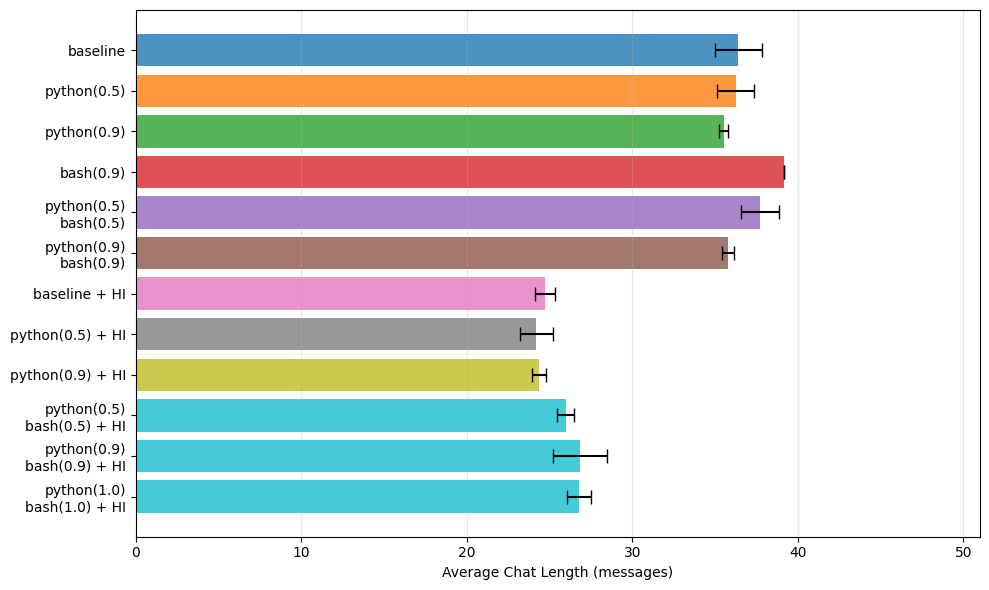

In [11]:
plot_bars_with_ci(results=msg_len_dict, xlabel="Average Chat Length (messages)", xlim=(0,51))

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Average Score (excluding max length chats)'>)

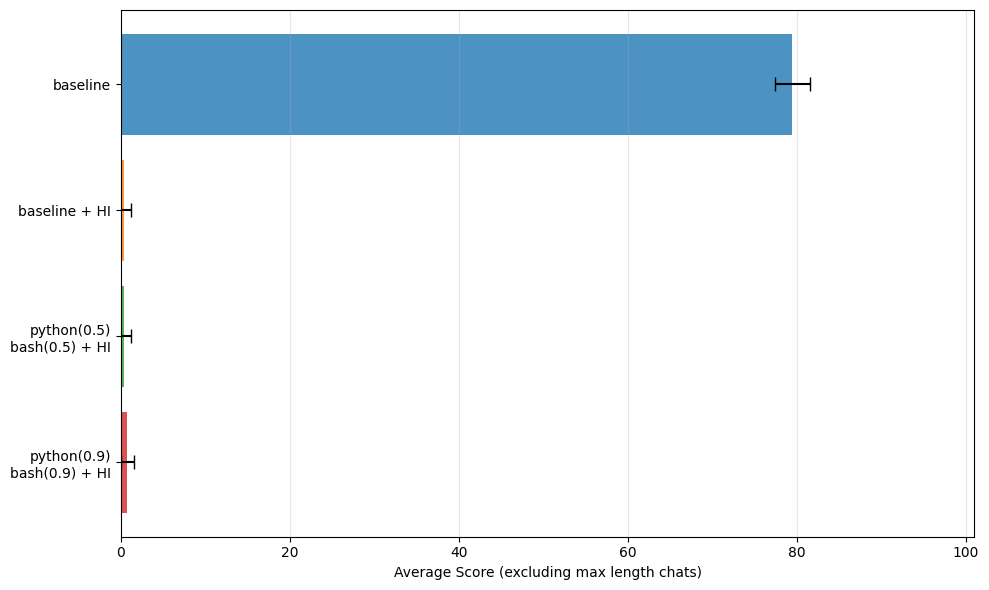

In [33]:
plot_bars_with_ci(results=scores_without_max_len, xlim=(0, 101), xlabel="Average Score (excluding max length chats)")

In [20]:
plot_bars_with_ci(results=max_msg_len, xlabel="Number of Chats with Max Length (50 messages)")

NameError: name 'max_msg_len' is not defined

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Mapping, Sequence


def plot_cumulative_message_histograms(
    message_counts_by_name: Mapping[str, Sequence[int]],
    bins: int | str | Sequence[int] = "auto",
    show: bool = True,
):
    """
    Plot cumulative probability histograms (CDFs) of total chat messages per sample
    for multiple eval runs on a single plot.

    Parameters
    ----------
    message_counts_by_name
        Mapping from a name/label to a sequence of integers.

        Each key is a label that will appear in the legend.
        Each value is a sequence of ints giving the total number of chat messages
        used for each eval sample in that run.

        Example:
            message_counts_by_name = {
                "gpt-5-mini": [3, 4, 4, 10, 2],
                "gpt-4.1":    [5, 6, 2, 8, 3, 3],
            }

    bins
        Binning strategy passed to numpy.histogram for a *shared* binning.
        - int: number of bins
        - "auto": let numpy choose from all concatenated data
        - sequence: explicit bin edges

    show
        If True, calls plt.show() at the end.

    Returns
    -------
    bin_edges : np.ndarray
        The edges of the bins (shared across all series).
    cdfs : dict[str, np.ndarray]
        Mapping from name to CDF array for that series
        (same length as bin_edges[1:]).
    """
    # Concatenate all data to get shared bin edges
    all_counts = np.concatenate(
        [np.asarray(v, dtype=int) for v in message_counts_by_name.values()]
    )

    # Get shared histogram bin edges from all data
    _, bin_edges = np.histogram(all_counts, bins=bins, density=True)
    bin_widths = np.diff(bin_edges)

    cdfs: dict[str, np.ndarray] = {}

    fig, ax = plt.subplots()

    for name, counts in message_counts_by_name.items():
        counts = np.asarray(counts, dtype=int)
        hist, _ = np.histogram(counts, bins=bin_edges, density=True)
        cdf = np.cumsum(hist * bin_widths)
        cdfs[name] = cdf

        ax.step(bin_edges[1:], cdf, where="post", label=name)

    ax.set_xlabel("Total chat messages per eval sample")
    ax.set_ylabel("Cumulative probability  P(N_messages ≤ x)")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Eval run")

    if show:
        plt.show()

    return bin_edges, cdfs



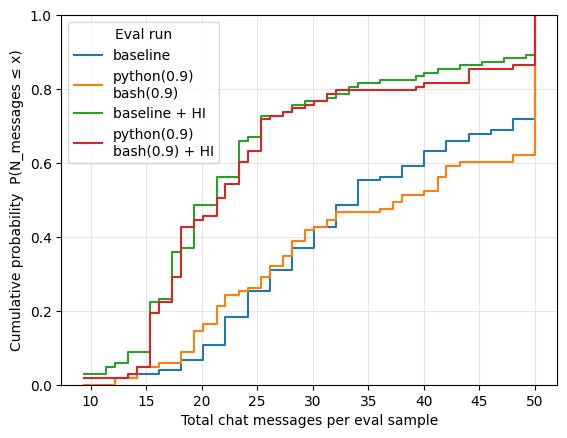

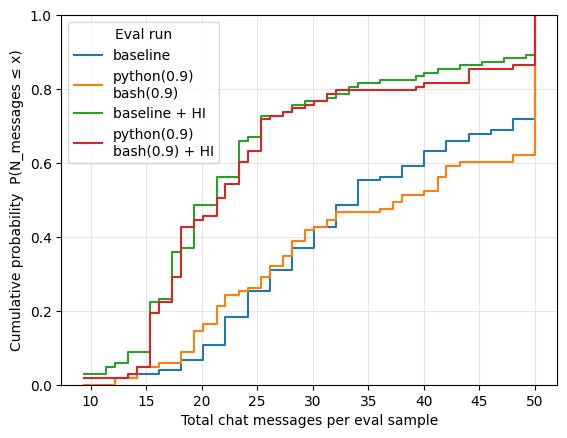

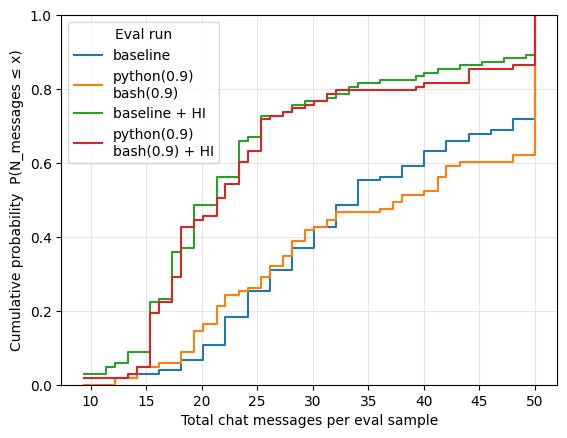

In [38]:
for i in [0, 1, 2]:
    num_chats_to_num_msgs_dict = {}

    for name, logs in logs_dict.items():
        num_chats_to_num_msgs_dict[name] = get_msgs_len(logs[0])#) for log in logs]

    keys_to_filter = [
        "baseline", "baseline + HI",
        "python(0.9)\nbash(0.9)", "python(0.9)\nbash(0.9) + HI"]
    num_chats_to_num_msgs_dict = {k:v for k,v in num_chats_to_num_msgs_dict.items() if k in keys_to_filter}
    plot_cumulative_message_histograms(num_chats_to_num_msgs_dict, bins=103, show=True);

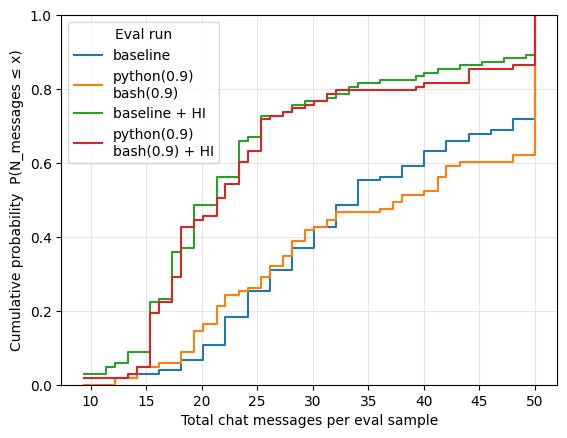

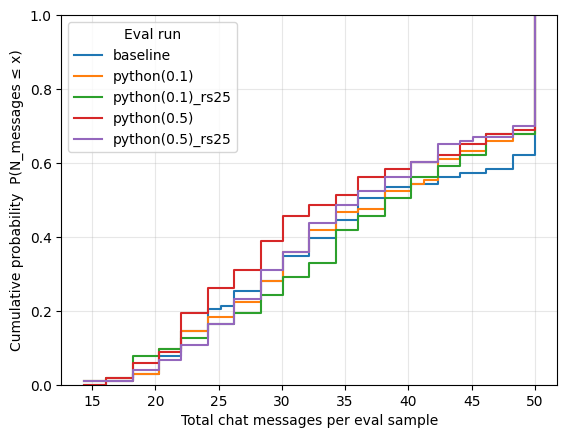

In [ ]:
plot_cumulative_message_histograms({name:num_chats_to_num_msgs_dict[name] for name in ["baseline", "python(0.1)", "python(0.1)_rs7", "python(0.5)", "python(0.5)_rs7"]}, bins=103, show=True);